# Customer Lifetime Value(CLTV) Prediction Using BG/NBD and Gamma Gamma Models in Python

Customer Lifetime Value(CLTV) is an important metric in marketing. CLTV is the predicted total amount of money a customer is expected to spend on your products. It gives your company a sensible view of the financial value provided by your customers. CLTV can be used as a KPI and as a loyalty measure. CLTV can be calculated based on the existing situation of your customers. You can also predict CLTV for the selected time periods in the future. For CLTV prediction, either statistical models or deep learning models can be used. I will use statistical models like BG/NBD and Gamma Gamma in this project. As a main package I will be using Python-lifetimes package. Firstly I will upload the necessary libraries and then read the data.csv file. 

It is a kaggle dataset in th link : https://www.kaggle.com/datasets/carrie1/ecommerce-data?datasetId=1985&sortBy=voteCount 

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import seaborn as sns

## Data Preprocessing

In [2]:
df = pd.read_csv('data.csv', encoding= 'unicode_escape')
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [3]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
531971,580981,20726,LUNCH BAG WOODLAND,10,12/6/2011 16:02,1.65,16201.00,United Kingdom
520947,580305,22973,CHILDREN'S CIRCUS PARADE MUG,1,12/2/2011 14:26,1.65,12970.00,United Kingdom
448378,575051,22071,SMALL WHITE RETROSPOT MUG IN BOX,2,11/8/2011 12:14,3.75,15957.00,United Kingdom
102430,545020,22697,GREEN REGENCY TEACUP AND SAUCER,6,2/25/2011 14:03,2.95,13792.00,United Kingdom
498917,578544,22114,HOT WATER BOTTLE TEA AND SYMPATHY,4,11/24/2011 15:01,4.25,17096.00,United Kingdom


When I look at null values, Description and CustomerID features has many. I will not use the Description feature so it is not important. But I will calculate CLTV specific to CustomerIDs so null values in this feature in meaningless. I will drop the null rows from the dataset. 

In [4]:
df.columns = ["INVOICE_ID", "STOCK_ID", "DESCRIPTION","AMOUNT", "INVOICE_DATE","PRICE","COMPANY_ID","COUNTRY"]
df =df[["INVOICE_ID", "STOCK_ID","AMOUNT", "INVOICE_DATE","PRICE","COMPANY_ID"]]

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_ID    406829 non-null  object 
 1   STOCK_ID      406829 non-null  object 
 2   AMOUNT        406829 non-null  int64  
 3   INVOICE_DATE  406829 non-null  object 
 4   PRICE         406829 non-null  float64
 5   COMPANY_ID    406829 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 21.7+ MB


In [6]:
df[["PRICE","AMOUNT"]].describe().T

,count,mean,std,min,25%,50%,75%,max
PRICE,406829.00,3.46,69.32,0.00,1.25,1.95,3.75,38970.00
AMOUNT,406829.00,12.06,248.69,-80995.00,2.00,5.00,12.00,80995.00


Invoice Date feature has object data type, so I will change it into datetime. Amount and Price values also have to be positive.

In [7]:
df["INVOICE_DATE"] = pd.to_datetime(df["INVOICE_DATE"])
df = df[(df["AMOUNT"] > 0) & (df["PRICE"]>0)]

The dataset has Price and Amount numeric features. I will take a look at outliers in these features with histogram graphic. 

<AxesSubplot: >

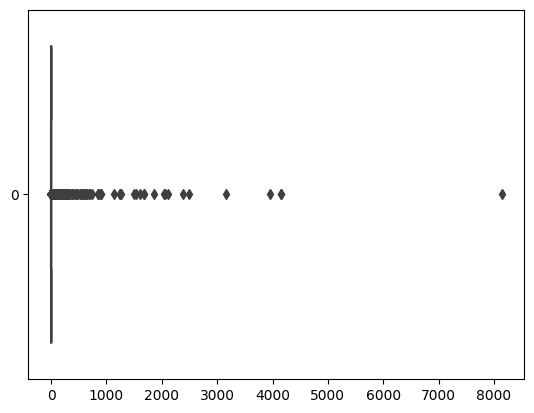

In [8]:
sns.boxplot(df["PRICE"], orient="h",notch=True, showcaps=False)

<AxesSubplot: >

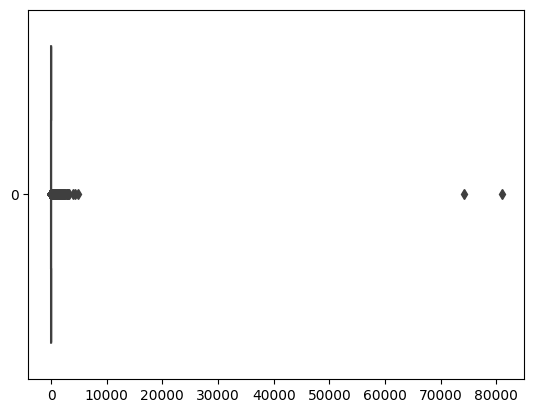

In [9]:
sns.boxplot(df["AMOUNT"], orient="h",notch=True, showcaps=False)

To get more meaningfull boxplot graphics we have to get rid of outliers. Dealing with outliers is a necessary process for data analysis. Outliers, whether they are too big or too small compared to expected values, have big impact on statistical values like mean and standard deviation. Thus for better prediction and analysis, we have to examine outlier values. There are a few ways to deal with outliers, but for this project I will replace outliers with threshold values that are evaluated in (0.05-0.95) range quantiles. I will hold down outlier values and replace them with their threshold values.  

In [10]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
replace_with_thresholds(df, "AMOUNT")
replace_with_thresholds(df, "PRICE")

After replacing outliers with threshold values, let's look at the boxplots again.

<AxesSubplot: >

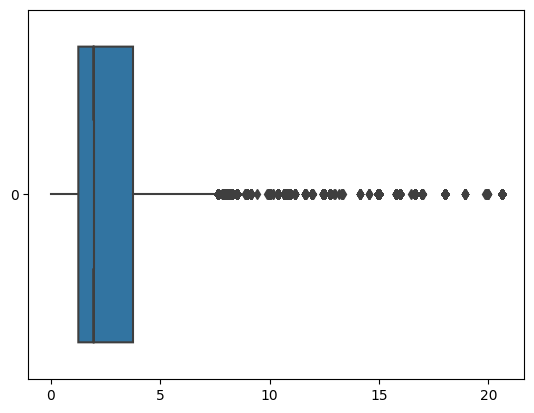

In [11]:
sns.boxplot(df["PRICE"], orient="h",notch=True, showcaps=False)

<AxesSubplot: >

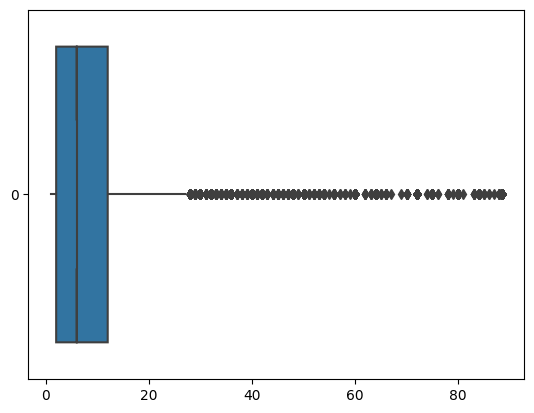

In [12]:
sns.boxplot(df["AMOUNT"], orient="h",notch=True, showcaps=False)

Now the data distributions for Price and Amount features make more sense for our CLV project. 

I need an ending date for CLTV calculation. I will find the max date in my dataset, add 2 days to this date and will use it as the ending date in calculation

In [13]:
df.INVOICE_DATE.max()

Timestamp('2011-12-09 12:50:00')

In [14]:
from datetime import timedelta
today_date= df.INVOICE_DATE.max() + timedelta(days=2)
today_date

Timestamp('2011-12-11 12:50:00')

We need Total Price feature to be able to calculate clv.

In [15]:
df["TOTAL_PRICE"] = df["AMOUNT"] * df["PRICE"]

### Frequency, Recency, Tenure and Monetary values

We need frequency, recency, tenure and monetary values for further calculations. We can calculate these values in a few steps but lifetimes library has already a function to calculate them easily. summary_data_from_transaction_data function gives us a dataframe with  frequency, recency, T and monetary_value columns. The function has "freq" feature that lets you to set a frequency. Options for "freq" are  "D" for daily,"W" fro weekly, "M" for monthly  and "Y" for yearly. I will set it to "W" to get weekly results.

frequency: How often a customer makes a purchase

recency: How recently a customer has made a purchase

T(tenure) : The customer age(for how many years has the customer been our customer)

monetary_value : Money value of the purchases

In [31]:
cltv_df = summary_data_from_transaction_data(df, 'COMPANY_ID','INVOICE_DATE','TOTAL_PRICE', 
                                                 include_first_transaction=True,
                                                 freq="W",
                                                observation_period_end = today_date)
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,4338.00,3.67,4.54,1.00,1.00,2.00,4.00,53.00
recency,4338.00,18.69,18.89,0.00,0.00,13.00,36.00,53.00
T,4338.00,31.63,16.83,0.00,16.00,35.00,46.00,53.00
monetary_value,4338.00,383.99,436.32,3.45,178.71,299.06,439.91,8803.60


## Modeling and Evaluation

BG-NBD stands for "Beta Geometric/Negative Binomial Distribution". The BG/NBD model is based on the historical purchase behavior of each customer to forecast his future activity. 

In [38]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_value'])

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary_value'],
                                   time=4,  # 1 yıllık
                                   freq="W",  # T'nin frekans bilgisi, haftalık:W
                                   discount_rate=0.01)
cltv=cltv.reset_index()
cltv_final= cltv_df.merge(cltv, on="COMPANY_ID", how="left")
cltv_final.sort_values('clv', ascending=False).head()

,COMPANY_ID,frequency,recency,T,monetary_value,clv
1689,14646.00,30.00,50.00,50.00,6658.81,59074.16
1289,14096.00,15.00,14.00,14.00,3554.60,40457.57
4201,18102.00,21.00,52.00,52.00,5840.23,36266.71
1879,14911.00,48.00,53.00,53.00,2756.06,36262.66
55,12415.00,14.00,45.00,48.00,6236.27,28507.88


## Segmentation according to CLTV values

I will create segments based on CLV values.

In [35]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.sort_values('clv', ascending=False).head()

,COMPANY_ID,frequency,recency,T,monetary_value,clv,segment
1689,14646.00,30.00,50.00,50.00,6658.81,59074.16,A
1289,14096.00,15.00,14.00,14.00,3554.60,40457.57,A
4201,18102.00,21.00,52.00,52.00,5840.23,36266.71,A
1879,14911.00,48.00,53.00,53.00,2756.06,36262.66,A
55,12415.00,14.00,45.00,48.00,6236.27,28507.88,A


In [36]:
cltv_final[cltv_final["segment"] =="B"].sort_values('clv', ascending=False).head()

,COMPANY_ID,frequency,recency,T,monetary_value,clv,segment
3441,17043.00,4.00,34.00,38.00,433.80,911.31,B
1512,14412.00,2.00,4.00,10.00,381.60,909.32,B
886,13527.00,6.00,41.00,46.00,381.25,908.65,B
1738,14712.00,3.00,12.00,16.00,305.69,908.46,B
730,13317.00,4.00,42.00,51.00,568.42,908.42,B


Son 10 daki müşteriler:
(CLV değeri çok çok düşük olan müşterilerin CLV değerini görebilmek için virgülden sonraki 10 basamağı görmek istiyorum)

In [37]:
cltv_final[cltv_final["segment"] =="D"].sort_values('clv', ascending=False).head()

,COMPANY_ID,frequency,recency,T,monetary_value,clv,segment
3451,17053.00,1.00,0.00,18.00,498.48,78.18,D
299,12715.00,1.00,0.00,15.00,315.10,78.18,D
2429,15653.00,2.00,3.00,16.00,87.72,78.11,D
2841,16213.00,1.00,0.00,11.00,159.00,77.82,D
4188,18084.00,1.00,0.00,2.00,25.66,77.48,D


## Further Insights

### Expected number of purchases with BG-NBD Model

Fitting BetaGeoFitter model is enough for further steps of CLTV prediction. But I will apply some other functions on this model to have more insights about future purchases.

<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

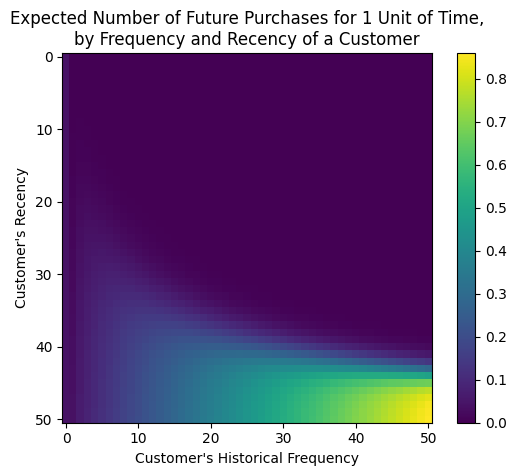

In [18]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf,max_frequency=50, max_recency=50)

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

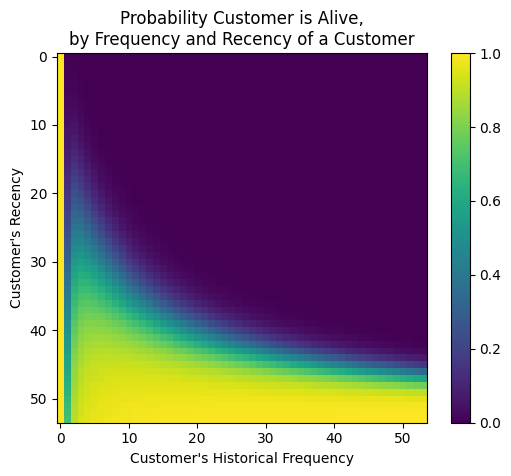

In [19]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

The customers who have higher recency and higher frequency are expected to purchase more products. As frequency increases if recency is low the probability of being alive is also low, if recency is high then the probability of being alive is higher. Actually to see the probability of being alive specific to each customer will be clarifying the second graph better.

### Purchase Latency


Purchase latency is a measure of the number of days between a customer’s orders. After the first order p_alive starts to occur for each customer. 

The average of the elapsed time between orders is recalculated for each order, resulting in a different p_alive. 

If a customer orders after a long time, that is much more than the previous average time interval, the rate of decrease of p_alive value decreases in the next long interval. In other words the probability of being alive decreases more slowly. And then the average time interval and probability of being alive function is calculated again. This holds on again and again as long as customer goes on puschasing.


<AxesSubplot: title={'center': 'History of P_alive'}, ylabel='P_alive'>

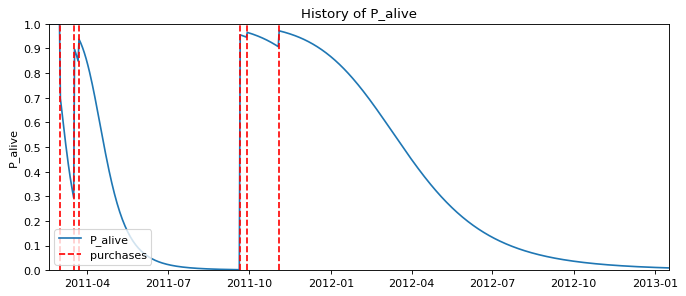

In [20]:
from matplotlib.pyplot import figure
from lifetimes.plotting import plot_history_alive
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
days_since_birth = 700
plot_history_alive(bgf, days_since_birth, df.loc[df["COMPANY_ID"] == 12352.00], 'INVOICE_DATE')

I will calculate expected number of purchases by using BG/NBD model and add to my dataframe.

In [21]:
cltv_df["expected_purc_1_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

### Testing purchase predictions with holdout group

C:\Users\nesrin.ozcan\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

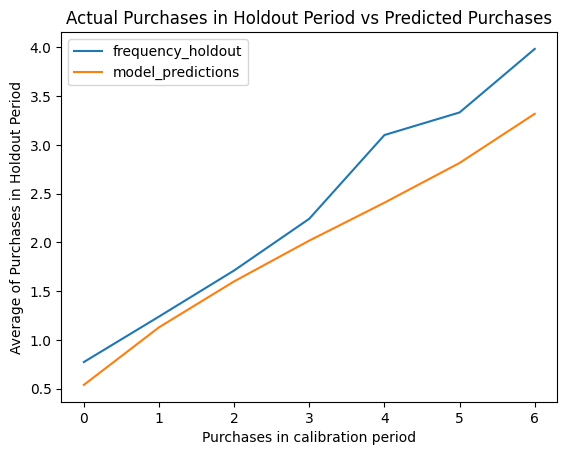

In [39]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

summary_cal_holdout = calibration_and_holdout_data(df, 
                                                   'COMPANY_ID', 
                                                   'INVOICE_DATE',
                                                    calibration_period_end='2011-08-01',
                                                    observation_period_end=today_date)
bgf.fit(summary_cal_holdout['frequency_cal'], 
       summary_cal_holdout['recency_cal'], 
      summary_cal_holdout['T_cal'],
       tol=1e-04)

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### GAMMA-GAMMA Model

I will use Gamma-Gamma Model's conditional_expected_average_profit function that calculates predicted average profit per transaction for each customer

In [23]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_value'])
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                               cltv_df['monetary_value'])
cltv_df.head()

,frequency,recency,T,monetary_value,expected_purc_1_month,expected_average_profit
COMPANY_ID,,,,,,
12346.00,1.00,0.00,46.00,92.04,0.00,115.69
12347.00,7.00,52.00,52.00,593.21,0.59,608.73
12348.00,4.00,40.00,51.00,353.80,0.36,370.71
12349.00,1.00,0.00,2.00,1458.84,0.58,1767.43
12350.00,1.00,0.00,44.00,315.02,0.00,385.15


## Conclusion

In conclusion, I have predicted clv, expected number of purchases and expected average profit for each curtomer for the next 4 weeks. Being aware of your best customers and who is likely to churn might be useful to create different marketing strategies for different segments of customers.  